### Overview
So far this summer I have worked on integrating filtering algorithms from Wes Fraser's PKBMOD repository. There are three algorithms here: `peak_offset_filter`, `predictive_line_cluster`, and `position_filter`. Although `position_filter` is currently stuck in limbo due to mysterious arguments, I have successfully poted over the other two algorithms.

### `peak_offset_filter`
`peak_offset_filter` is a fairly simple algorithm which filters out results where the brightest pixel is a specified radius away from the center. The default radius is 6. Integrating this filter into KBMOD proved fairly simple since the filter comprises of little more than a few `numpy` operations.

```python
def peak_offset_filter(res, peak_offset_max=6):
    stamps = res["coadd_mean"]
    (N, a, b) = stamps.shape
    (gx, gy) = np.meshgrid(np.arange(b), np.arange(a))
    gx = gx.reshape(a * b)
    gy = gy.reshape(a * b)
    rs_stamps = stamps.reshape(N, a * b)
    args = np.argmax(rs_stamps, axis=1)
    X = gx[args]
    Y = gy[args]
    radial_d = ((X - b / 2) ** 2 + (Y - a / 2) ** 2) ** 0.5
    w = np.where(radial_d < peak_offset_max)
    res.table = res.table[w]
```

The chart below shows the effect of three filters -- including `peak_offset_filter` with a `peak_offset_max` of `1` -- on a small 7 GB work unit that has 945 results without any filters. The two other filters are sigma-G and clustering.

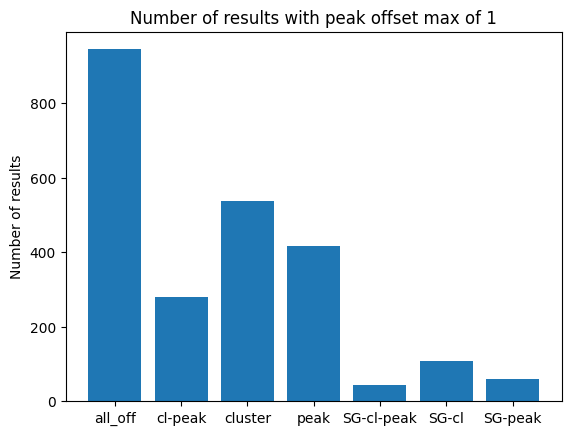

The chart below is the same as the above but with a default `peak_offset_max` of `6`.

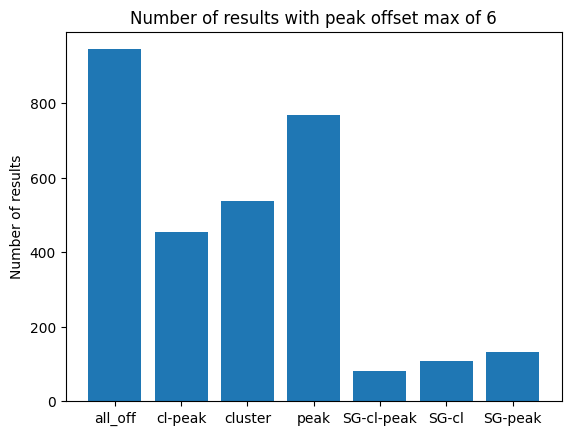

Testing for this filter included the edge cases of having `peak_offset_max` of zero which should filter everything out and an absurdly large `peak_offset_max` (I chose 10,000) which filters everything out. I also added a fake object and intentionally moved the trajectory's start point by 2 pixels to ensure that the algorithm correctly filtered the corresponding result out.

### `predictive_line_cluster`

`predictive_line_cluster` is a more complicated algorithm than 'peak_offset_filter' and required more changes in order to integrate. The high level overview of how `predictive_line_cluster` works remains a mystery.

Parts of this function required re-writing to work with the existing KBMOD structure. The simplest change was calculating the `max_snr` of each row in the input `Results` since the algorithm used that but assumed it is an existing column in the original function. Another change extracting each of the four relevant columns -- `x`, `y`, `vx`, and `vy` -- and directly working with them as opposed to the `Results` object as a whole since the original function used a `numpy` array and worked with the properly indexed columns.

Lastly, the original code repeatedly filtered rows out during iterations in a `while` loop by adding the rows to *keep* to a list then returning a `numpy` array constructed from the rows in that list. The algorithm also saved the row indices of the returned rows relative to the original input array. I modified the algorithm to not keep track of the list of rows and instead just used the saved indices to remove any rows whose indices were not saved.

The `predictive_line_cluster` algorithm showed a remarkable impact on the small work unit from earlier. Without any of the three filters mentioned previously, `predictive_line_cluster` alone reduced reduced 945 rows to a little over 80. The same two bar graphs from above -- but now with `predictive_line_cluster` active -- are shown below:

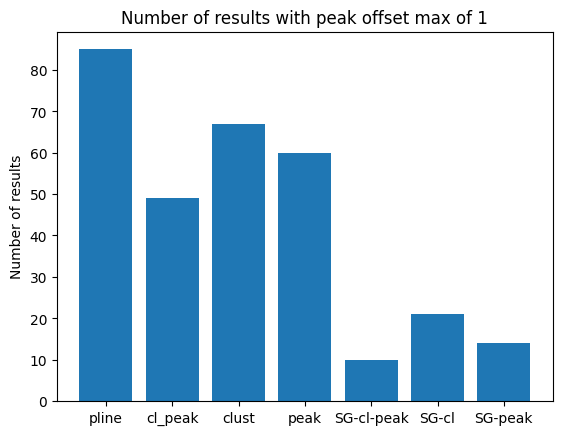

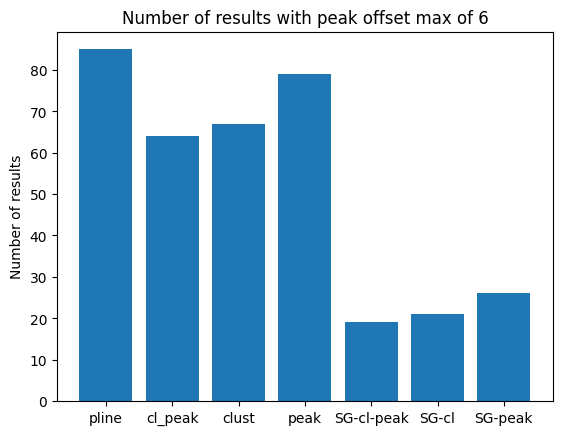

I implemented two tests for this filter. In the first, a fake data set with 6 identical trajectories is run through the filter to ensure that that only one row in the `Results` survives. In the second, one trajectory is inserted and then four other trajectories where the starting `x` and `y` values differ by `±1` to test if the filter clusters all 5 rows into the first one inserted.